In [1]:
import os
import time

import numpy as np
import matplotlib.pyplot as plt

import pybullet_envs
import torch as th
import gym
from typing import Callable

from stable_baselines3 import PPO
from stable_baselines3.common.policies import ActorCriticPolicy
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common import results_plotter
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback

In [2]:
class SaveOnBestReward(BaseCallback):
    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(SaveOnBestReward, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

          # Retrieve training reward
          x, y = ts2xy(load_results(self.log_dir), 'timesteps')
          if len(x) > 0:
              # Mean training reward over the last 100 episodes
              mean_reward = np.mean(y[-100:])
              if self.verbose > 0:
                print(f"Num timesteps: {self.num_timesteps}")
                print(f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}")

              # New best model, you could save the agent here
              if mean_reward > self.best_mean_reward:
                  self.best_mean_reward = mean_reward
                  # Example for saving best model
                  if self.verbose > 0:
                    print(f"Saving new best model to {self.save_path}.zip")
                  self.model.save(self.save_path)

        return True

In [3]:
def make_env(env_id, rank, seed=0) -> Callable:
    def _init() -> gym.Env:
        env = gym.make(env_id)
        env = Monitor(env, log_dir)
        env.seed(seed + rank)
#         log_sub_dir = f"{log_dir}/env_{rank}"
#         os.makedirs(log_sub_dir, exist_ok=True)
        return env
    set_random_seed(seed)
    return _init

In [9]:
v = "4"
d = "humanoid"
log_dir = f"{d}/humanoid_log_{v}/"
os.makedirs(log_dir, exist_ok=True)

env_id = "HumanoidBulletEnv-v0"
num_cpu = 8

callback = SaveOnBestReward(check_freq=1000, log_dir=log_dir)

env = DummyVecEnv([make_env(env_id, i) for i in range(num_cpu)])

C:\Users\User\anaconda3\envs\r1\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [10]:
policy_kwargs = dict(activation_fn=th.nn.ReLU,
                     net_arch=[dict(pi=[256,256,256,128], vf=[256,256,256,128])])

def learning_rate(frac):
    return 1.0e-4*(np.exp(6*(frac-1)))

model = PPO('MlpPolicy', env, verbose=0, policy_kwargs=policy_kwargs, learning_rate=learning_rate, tensorboard_log=log_dir)

In [11]:
eval_env = Monitor(gym.make(env_id))

mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes = 50)
print(f'Mean reward: {mean_reward} +/- {std_reward:.2f}')

Mean reward: 51.37604100000001 +/- 12.00


In [12]:
model.learn(total_timesteps=50000, callback=callback)

model.save(f"{d}/humanoid_l{v}")
del model

ParserError: Error tokenizing data. C error: Expected 3 fields in line 6, saw 7


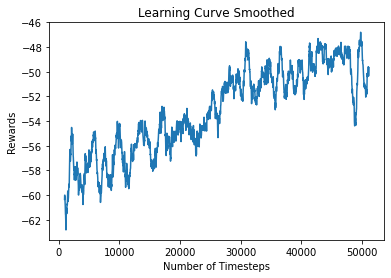

In [8]:
def moving_average(values, window):
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')

def plot_results(log_folder, title='Learning Curve'):
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    y = moving_average(y, window=50)
    # Truncate x
    x = x[len(x) - len(y):]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.title(title + " Smoothed")
    plt.show()
    
plot_results(log_dir)

In [10]:
# Can't render for some reason, but able to see in script

# eval_env.render()
# model = PPO.load(f"{d}/humanoid_l{v}", env = eval_env)
# obs = eval_env.reset()
# for i in range(500):
#     action, _state = model.predict(obs, deterministic=True)
#     obs, reward, done, info = eval_env.step(action)
#     eval_env.render()
#     time.sleep(1/200)
#     if done:
#         obs = eval_env.reset()